In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
from matplotlib import mlab
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [4]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [5]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.15
delty3_true = .3
sigsq1_true = .01
sigsq2_true = .04
sigsq3_true = .04
a1_true = .5
a2_true = .3
a3_true = .2

In [72]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, delty3, sigsq1, sigsq2, sigsq3, a1, a2= theta
    a3 = 1.0 - a1 - a2
    delty1 = 0
    delty2 = .15
    delty3 = .3
    sigsq1 = .01
    sigsq2 = .04
    sigsq3 = .01
#     a1 = .5
#     a2 = .3
#     a3 = .2
#     delty3 = b - 3*np.sqrt(sigsq3)
    mod1 = y + delty1 - m*x - b
    mod2 = y + delty2 - m*x - b
    mod3 = y + delty3 - m*x - b
#     return np.sum(np.log(a1/np.sqrt(2*np.pi*sigsq1))) - np.sum(-((mod1)**2)/(2*sigsq1)) \
#         + np.sum(np.log(1-(a2/a1)*(np.sqrt(sigsq1/sigsq2))*((sigsq1*(mod1)**2+sigsq2*(mod2)**2)/(2*sigsq1*sigsq2))))
    return np.sum(np.log(((a1/(np.sqrt(2*np.pi*sigsq1)))*np.exp((-(mod1)**2)/(2*sigsq1))+ \
                           ((a2/(np.sqrt(2*np.pi*sigsq2)))*np.exp((-(mod2)**2)/(2*sigsq2))) + \
                           ((a3/(np.sqrt(2*np.pi*sigsq3)))*np.exp((-(mod3)**2)/(2*sigsq3))) )))

In [73]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, delty3_true, sigsq1_true, sigsq2_true, sigsq3_true, a1_true, a2_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, delty3_ml, sigsq1_ml, sigsq2_ml, sigsq3_ml, a1_ml, a2_ml= result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


In [74]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml, a2_ml)

0.0 0.5 0.0 0.15 0.01 0.04 0.5 0.3


In [75]:
def lnprior(theta):
    m, b, delty1, delty2, delty3, sigsq1, sigsq2, sigsq3, a1, a2= theta
#     if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and a1+a2 <= 1.0: 
# np.sqrt(sigsq1) <= delty2 <= np.sqrt(sigsq1) + np.sqrt(sigsq2) and delty3 <= np.sqrt(sigsq2) + np.sqrt(sigsq3) + delty2
    if 0.0 < b < 1.0 \
        and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and a1+a2 <= 1.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
#         pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
#         pri_delty3 = norm.logpdf(delty3, 0.3, 0.5)
#         pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
#         pri_sigsq2 = halfnorm.logpdf(sigsq2, .04, .01)
#         pri_sigsq3 = halfnorm.logpdf(sigsq3, .04, .01)
        pri_a1 = halfnorm.logpdf(a1, 0.0, 1.0/5.0)
        return pri_m + pri_a1
    return -np.inf

In [76]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [77]:
ndim, nwalkers = 10, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, 0.0, 0.15, 0.3, .01, .04, .04, .5, .3] for i in range(nwalkers)]

In [78]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

In [79]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  2.16523765e-06,   5.59680790e-01,   0.00000000e+00, ...,
           1.13195001e+15,   8.23861388e-01,   1.73711861e-01],
        [ -2.65131042e-06,   5.48942654e-01,   0.00000000e+00, ...,
           5.46996450e+15,   9.04661946e-01,   2.79308877e-04],
        [  2.59236848e-06,   5.43460410e-01,   0.00000000e+00, ...,
           4.47129984e+15,   8.62368798e-01,   8.60091405e-02],
        ..., 
        [ -8.37254394e-06,   5.80208275e-01,   0.00000000e+00, ...,
          -6.49132571e+14,   8.53913120e-01,   1.14579210e-01],
        [ -7.65572698e-06,   5.71805775e-01,   0.00000000e+00, ...,
           4.29526716e+15,   8.84005262e-01,   1.14959845e-01],
        [ -1.72059890e-06,   5.61434088e-01,   0.00000000e+00, ...,
           7.07707066e+15,   9.57922889e-01,   2.72347806e-02]]),
 array([ 449.08377737,  445.24529358,  445.86993795,  401.55071764,
         449.57394929,  448.82046479,  400.77024711,  452.20120089,
         447.95078945,  447.85404592,  443.71052436,  44

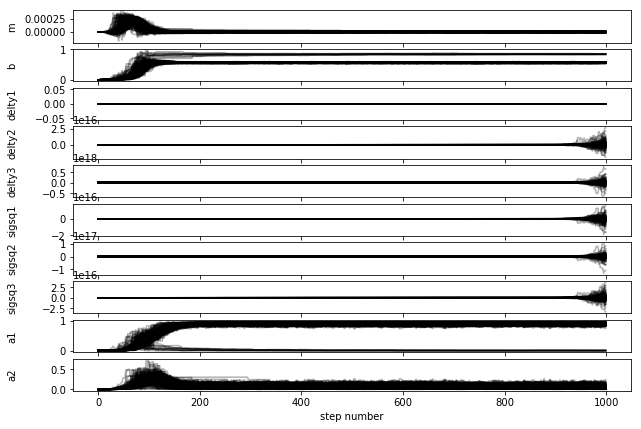

In [80]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "delty3", "sigsq1", "sigsq2", "sigsq3", "a1", "a2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_3gauss_test.png")
plt.show()

In [81]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

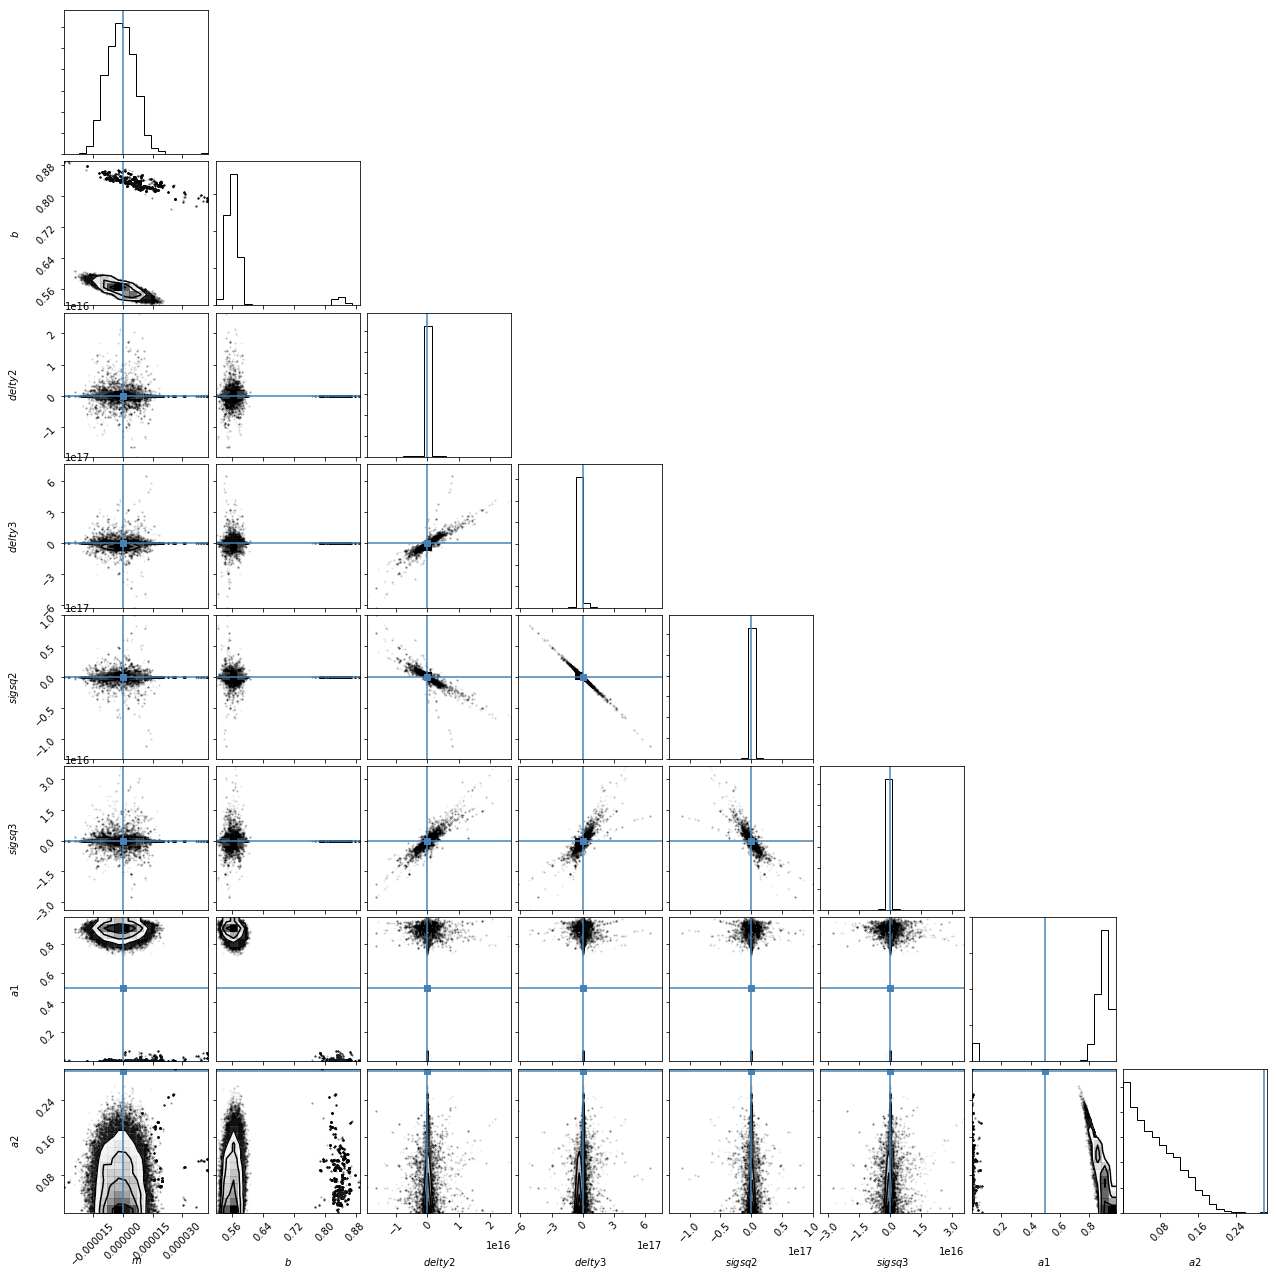

In [82]:
fig = corner.corner(flat_samples[:,[0, 1, 3, 4, 6, 7, 8, 9]], labels=["$m$", "$b$", "$delty2$", "$delty3$", "$sigsq2$", "$sigsq3$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, delty2_true, delty3_true, sigsq2_true, sigsq3_true, a1_true, a2_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_3gauss_test.png")

In [83]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

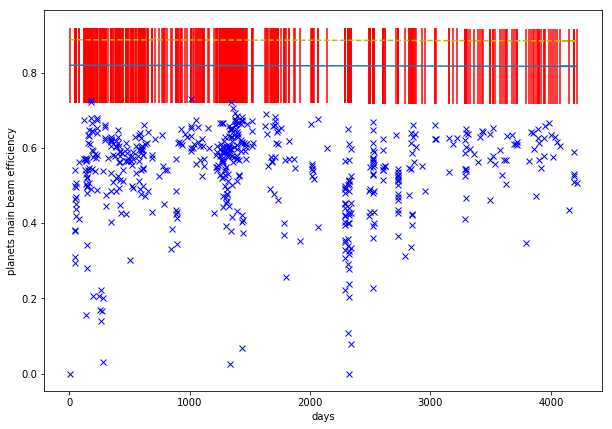

In [52]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
y = m*days + b
yerr = np.sqrt(.01)
bias = results[3][1]
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.errorbar(days, y, yerr=yerr, ecolor='red')
plt.plot(days, y - bias, '--', color='y')
plt.show()

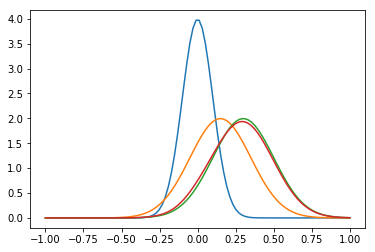

In [53]:
plt.figure(1)
x = np.linspace(-1.0, 1.0, 100)
plt.plot(x, mlab.normpdf(x, delty1_true, np.sqrt(sigsq1_true)))
plt.plot(x, mlab.normpdf(x, delty2_true, np.sqrt(sigsq2_true)))
plt.plot(x, mlab.normpdf(x, delty3_true, np.sqrt(sigsq3_true)))
plt.plot(x, results[-2][1]*mlab.normpdf(x, delty1_true, np.sqrt(sigsq1_true))+ results[-1][1]*mlab.normpdf(x, delty2_true, np.sqrt(sigsq2_true))+ (1.0-results[-2][1]-results[-1][1])*mlab.normpdf(x, delty3_true, np.sqrt(sigsq3_true)))
plt.show()